In [1]:
import gensim
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', 400)
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem.snowball import SnowballStemmer
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from lime import lime_text
import tensorflow.keras.preprocessing
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import create_optimizer
from transformers import DataCollatorWithPadding
from datasets import Dataset
from os.path import exists

In [2]:
train = pd.read_csv('data/reddit_200k_train.csv', encoding='ISO-8859-1')
test = pd.read_csv('data/reddit_200k_test.csv', encoding='ISO-8859-1')

In [3]:
train.head()
#score.x appears to be upvotes?

,Unnamed: 0,body,score.x,parent_id.x,id,created_utc.x,retrieved_on,REMOVED
0,1,I've always been taught it emerged from the earth after an impace. That is why it has similar elemental distribution to earth,2,t3_81u15i,dv551g6,1520121101,1524782256,False
1,2,"As an ECE, my first feeling as ""HEY THAT'S NOT-"" and then I thought about all the times my co-workers couldn't even write a simple message in our communication book without making mistakes. \r\n\r\nI'm getting out of the profession.",2,t3_72sk35,dnl66g6,1506533157,1507150439,True
2,3,Monday: Drug companies stock dives on good news for patients.,5,t3_8o88yr,e02sjhz,1528087570,1532170350,True
3,4,i learned that all hybrids are unfertile i wont read clickbaits https://biology.stackexchange.com/questions/16922/why-are-hybrids-infertile,0,t3_6xg9t8,dmfojjp,1504290041,1506407514,False
4,5,Well i was wanting to get wasted tonight. Not so much after reading this article...,3,t3_99wi9m,e4rtew8,1535140675,1537893540,False


In [4]:
print('Length of train split:', len(train))
print('Length of test split:', len(test))
print('Relative test split size:', 1/((len(test)+len(train))/len(test)))

Length of train split: 167529
Length of test split: 55843
Relative test split size: 0.25


Label distribution:
 False    0.61492
True     0.38508
Name: REMOVED, dtype: float64


Text(1.93, 0.43507959815912467, '38.51%')

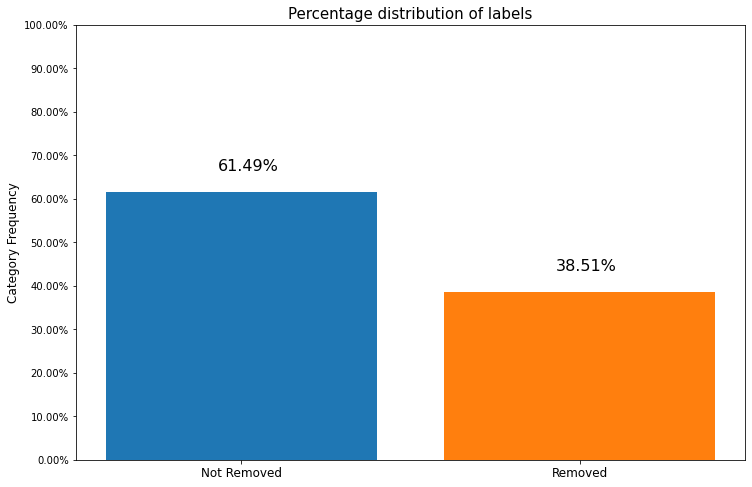

In [5]:
percentage_not_removed = pd.concat([train['REMOVED'], test['REMOVED']]).value_counts(normalize=True)[0]
percentage_removed = pd.concat([train['REMOVED'], test['REMOVED']]).value_counts(normalize=True)[1]
print('Label distribution:\n', pd.concat([train['REMOVED'], test['REMOVED']]).value_counts(normalize=True))

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(1, percentage_not_removed, label='Not Removed')
ax.bar(2, percentage_removed, label='Removed')
ax.set_title('Percentage distribution of labels', fontsize=15)
plt.xticks([1,2],['Not Removed', 'Removed'], fontsize=12)
plt.tick_params(
    axis='x',
    which='minor',
    bottom=False,
    top=False,
    labelbottom=False)
plt.ylabel('Category Frequency', fontsize=12)
plt.ylim(0, 1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=2))
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.text(1 -0.07, percentage_not_removed + 0.05, "{:.2%}".format(percentage_not_removed), fontsize=16)
plt.text(2 -0.07, percentage_removed + 0.05, "{:.2%}".format(percentage_removed), fontsize=16)

In [6]:
# Comment removal messages are contained in this set, too.
# Since these are automated or from moderators, they do not 
# represent the kinds of comments the model will actually be working with.
train.loc[train['body'].str.contains('has been removed because')]

,Unnamed: 0,body,score.x,parent_id.x,id,created_utc.x,retrieved_on,REMOVED
425,426,"Hi Z0idberg_MD, your submission has been removed for the following reason(s)\r\n \r\nYour submission has been removed because flair has not been assigned. \r\n \r\n*This removal was automatic. If you feel this was done in error, or would like further clarification, please add flair to the post and then [message the mods](http://www.reddit.com/message/compose?to=%2Fr%2FScience&amp;amp;message=M...",4,t3_78bxng,dosmmc6,1508803513,1510120310,False
470,471,"Hi 432_Hz, your submission has been removed for the following reason(s)\r\n \r\nYour submission has been removed because flair has not been assigned. \r\n \r\n*This removal was automatic. If you feel this was done in error, or would like further clarification, please add flair to the post and then [message the mods](http://www.reddit.com/message/compose?to=%2Fr%2FScience&amp;amp;message=My%20P...",2,t3_7gu35y,dqlpg3r,1512123314,1514226457,True
1736,1737,"Hi xxxlovelit, your submission has been removed for the following reason(s)\r\n \r\nYour submission has been removed because flair has not been assigned. \r\n \r\n*This removal was automatic. If you feel this was done in error, or would like further clarification, please add flair to the post and then [message the mods](http://www.reddit.com/message/compose?to=%2Fr%2FScience&amp;amp;message=My...",0,t3_9hqtmi,e6dssic,1537543212,1539369659,True
1890,1891,"Hi FM9022, your submission has been removed for the following reason(s)\r\n \r\nYour submission has been removed because flair has not been assigned. \r\n \r\n*This removal was automatic. If you feel this was done in error, or would like further clarification, please add flair to the post and then [message the mods](http://www.reddit.com/message/compose?to=%2Fr%2FScience&amp;amp;message=My%20P...",2,t3_7eywxu,dq8cqef,1511435412,1512927391,True
1972,1973,"Hi kolorful, your submission has been removed for the following reason(s)\r\n \r\nYour submission has been removed because flair has not been assigned. \r\n \r\n*This removal was automatic. If you feel this was done in error, or would like further clarification, please add flair to the post and then [message the mods](http://www.reddit.com/message/compose?to=%2Fr%2FScience&amp;amp;message=My%2...",2,t3_5x6s6e,defpo78,1488497714,1491157692,False
...,...,...,...,...,...,...,...,...
164288,164289,"Hi drewiepoodle, your submission has been removed for the following reason(s)\r\n \r\nYour submission has been removed because flair has not been assigned. \r\n \r\n*This removal was automatic. If you feel this was done in error, or would like further clarification, please add flair to the post and then [message the mods](http://www.reddit.com/message/compose?to=%2Fr%2FScience&amp;amp;message=...",0,t3_8nj7gg,dzvukp6,1527780311,1528193263,True
164987,164988,"Your submission has been removed because it violates our submission rules. Please read the [Rules for Headlines](https://www.reddit.com/r/science/wiki/clickbait) and contact the mods if you have further questions.\r\n\r\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/science) if you have any questions or conce...",2,t3_5n65jd,dc8x5ab,1484067606,1485934698,False
165061,165062,"Your submission has been removed because it violates our submission rules. Please read the [Rules for Headlines](https://www.reddit.com/r/science/wiki/clickbait) and contact the mods if you have further questions.\r\n\r\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/science) if you have any questions or conce...",2,t3_8kh0eu,dz7kvv3,1526682161,1527680654,False
166707,166708,"Hi giraldita, your submission has been removed for the following reason(s)\r\n \r\nYour submission has been removed because flair has not been assigned. \r\n \r\n*This removal was automatic.

In [7]:
stopwords_list = stopwords.words('english')

def remove_stopwords(input_list):
    output_list = []
    for word in input_list:
        if word not in stopwords_list:
            output_list.append(word)
    return output_list


def clean_input(input_df):
    df = input_df.copy() #copy df 

    #drop useless columns
    df.drop(['Unnamed: 0', 'score.x', 'parent_id.x', 'id', 'created_utc.x', 'retrieved_on'], axis=1, inplace=True)
    
    #lowercase
    df.body = df.body.str.lower()
    
    #drop all rows matching removal text
    df.drop(
        df.loc[df['body'].str.contains('your submission has been removed for the following')].index,
        inplace=True
    )
    
    df.drop(
        df.loc[df['body'].str.contains('has been removed because')].index,
        inplace=True
    )
    
    #strip special characters and tokenize
    pattern = r"(?u)\b\w\w+\b"
    tokenizer = RegexpTokenizer(pattern)
    df['tokenized'] = df['body'].apply(tokenizer.tokenize)
    
    #remove stopwords
    df['no_stop'] = df['tokenized'].apply(remove_stopwords)
    
    #lemma
    lemma = nltk.stem.wordnet.WordNetLemmatizer()
    df['lemma'] = df['no_stop'].apply(lambda x: [lemma.lemmatize(y) for y in x])
    
    #save seperately as string
    df['clean_string'] = df['lemma'].apply(lambda x: ' '.join(x))
    
    #drop NaNs
    df.drop(df.loc[df['clean_string'].isna()].index, inplace=True)
    
    #drop empty strings
    df.drop(df.loc[df['clean_string'] == ''].index, inplace=True)
    #print(df.isna().sum())

    return df

#load cleaned csv if it already exists, otherwise clean and save
if exists('data/data_cleaned.csv'):
    data_cleaned = pd.read_csv('data/data_cleaned.csv', index_col='Unnamed: 0')

else:
    train_cleaned = clean_input(train)
    test_cleaned = clean_input(test)

    data_cleaned = pd.concat([train_cleaned, test_cleaned])
    data_cleaned.reset_index(inplace=True)
    data_cleaned.drop(['index'], axis=1, inplace=True)
    #data_cleaned.head()
    data_cleaned.to_csv('data/data_cleaned.csv')
    data_cleaned = pd.read_csv('data/data_cleaned.csv', index_col='Unnamed: 0')

In [8]:
data_cleaned.head()
#remember to check if the output of this cell is the same if saving or loading

,body,REMOVED,tokenized,no_stop,lemma,clean_string
0,i've always been taught it emerged from the earth after an impace. that is why it has similar elemental distribution to earth,False,"['ve', 'always', 'been', 'taught', 'it', 'emerged', 'from', 'the', 'earth', 'after', 'an', 'impace', 'that', 'is', 'why', 'it', 'has', 'similar', 'elemental', 'distribution', 'to', 'earth']","['always', 'taught', 'emerged', 'earth', 'impace', 'similar', 'elemental', 'distribution', 'earth']","['always', 'taught', 'emerged', 'earth', 'impace', 'similar', 'elemental', 'distribution', 'earth']",always taught emerged earth impace similar elemental distribution earth
1,"as an ece, my first feeling as ""hey that's not-"" and then i thought about all the times my co-workers couldn't even write a simple message in our communication book without making mistakes. \r\n\r\ni'm getting out of the profession.",True,"['as', 'an', 'ece', 'my', 'first', 'feeling', 'as', 'hey', 'that', 'not', 'and', 'then', 'thought', 'about', 'all', 'the', 'times', 'my', 'co', 'workers', 'couldn', 'even', 'write', 'simple', 'message', 'in', 'our', 'communication', 'book', 'without', 'making', 'mistakes', 'getting', 'out', 'of', 'the', 'profession']","['ece', 'first', 'feeling', 'hey', 'thought', 'times', 'co', 'workers', 'even', 'write', 'simple', 'message', 'communication', 'book', 'without', 'making', 'mistakes', 'getting', 'profession']","['ece', 'first', 'feeling', 'hey', 'thought', 'time', 'co', 'worker', 'even', 'write', 'simple', 'message', 'communication', 'book', 'without', 'making', 'mistake', 'getting', 'profession']",ece first feeling hey thought time co worker even write simple message communication book without making mistake getting profession
2,monday: drug companies stock dives on good news for patients.,True,"['monday', 'drug', 'companies', 'stock', 'dives', 'on', 'good', 'news', 'for', 'patients']","['monday', 'drug', 'companies', 'stock', 'dives', 'good', 'news', 'patients']","['monday', 'drug', 'company', 'stock', 'dive', 'good', 'news', 'patient']",monday drug company stock dive good news patient
3,i learned that all hybrids are unfertile i wont read clickbaits https://biology.stackexchange.com/questions/16922/why-are-hybrids-infertile,False,"['learned', 'that', 'all', 'hybrids', 'are', 'unfertile', 'wont', 'read', 'clickbaits', 'https', 'biology', 'stackexchange', 'com', 'questions', '16922', 'why', 'are', 'hybrids', 'infertile']","['learned', 'hybrids', 'unfertile', 'wont', 'read', 'clickbaits', 'https', 'biology', 'stackexchange', 'com', 'questions', '16922', 'hybrids', 'infertile']","['learned', 'hybrid', 'unfertile', 'wont', 'read', 'clickbaits', 'http', 'biology', 'stackexchange', 'com', 'question', '16922', 'hybrid', 'infertile']",learned hybrid unfertile wont read clickbaits http biology stackexchange com question 16922 hybrid infertile
4,well i was wanting to get wasted tonight. not so much after reading this article...,False,"['well', 'was', 'wanting', 'to', 'get', 'wasted', 'tonight', 'not', 'so', 'much', 'after', 'reading', 'this', 'article']","['well', 'wanting', 'get', 'wasted', 'tonight', 'much', 'reading', 'article']","['well', 'wanting', 'get', 'wasted', 'tonight', 'much', 'reading', 'article']",well wanting get wasted tonight much reading article


In [9]:
#models
    #baseline NB
    #NB, stop/lemma
    #LSTM, autoembedding
    #LSTM w2v
    #LSTM glove
    #bert
    
#p3 model metric displays
def getConfusionMatrix(estimator, data, target, labels=None):
    preds = estimator.predict(data)
    matrix_raw = confusion_matrix(target, preds)
    dfMatrix = pd.DataFrame(matrix_raw, index=labels, columns=labels)
    plt.subplots(figsize=(16,8))
    sns.heatmap(dfMatrix, annot=True, robust=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    return dfMatrix

def getScore(estimator, data, target, labels = None):
    preds = estimator.predict(data)
    results = {}
    results['Accuracy'] = accuracy_score(target, preds)
    results['F1'] = f1_score(target, preds, average='binary')
    results['Recall'] = recall_score(target, preds, average='binary')
    results['Precision'] = precision_score(target, preds, average='binary')
    
    dfResults = pd.DataFrame(results, index=labels)
    #print(dfResults)
    plt.subplots(figsize=(16,8))
    sns.heatmap(dfResults, annot=True, robust=True, cmap='Greens', fmt='0.5g')
    plt.title('Model Performance Summary')
    plt.ylabel('Category')
    return dfResults

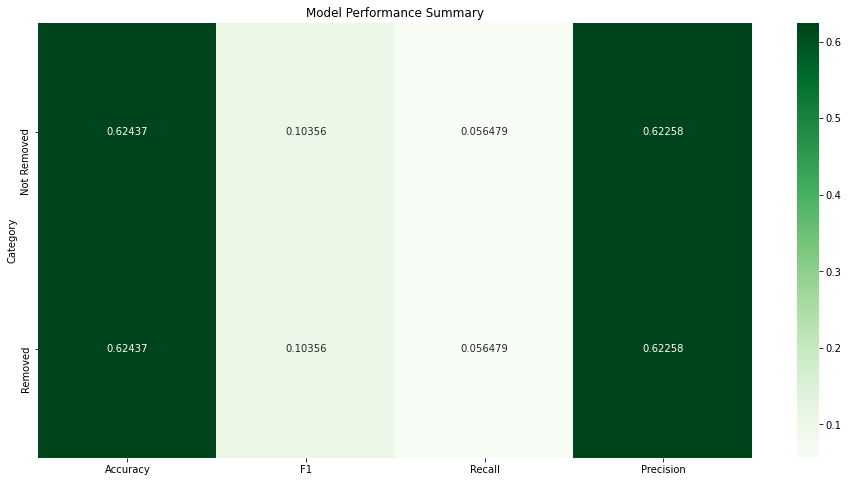

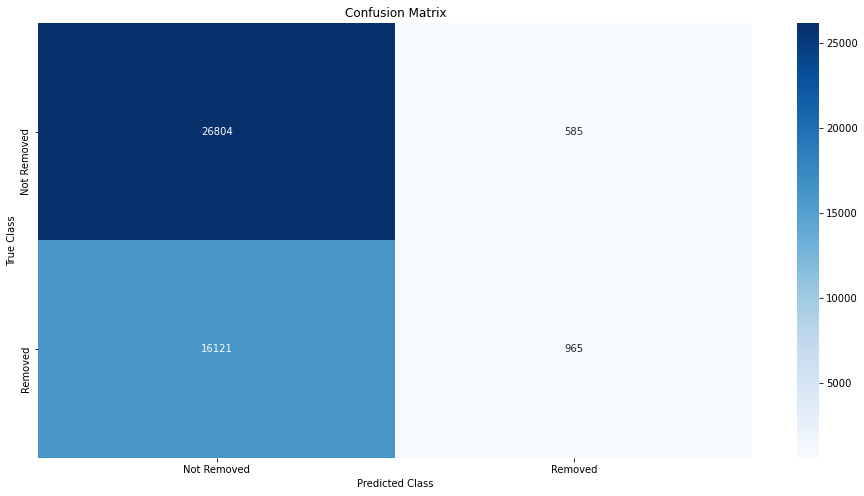

In [10]:
#baseline NB
#just tfidf, no lemma or stopword removal
X = data_cleaned['body']
y = data_cleaned['REMOVED']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=8492)

tfidf = TfidfVectorizer(max_features=100)

X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

baseline_model = MultinomialNB()

baseline_model.fit(X_train_vectorized, y_train)

labels = ['Not Removed', 'Removed']
test_baseline = getScore(baseline_model, X_test_vectorized, y_test, labels)
conf_baseline = getConfusionMatrix(baseline_model, X_test_vectorized, y_test, labels)

In [11]:
#baseline is only about %0.7 better than just picking majority class (not removed)
y_test.value_counts(normalize=True)
#need to fix getScore, probably rewrite it

False    0.615829
True     0.384171
Name: REMOVED, dtype: float64

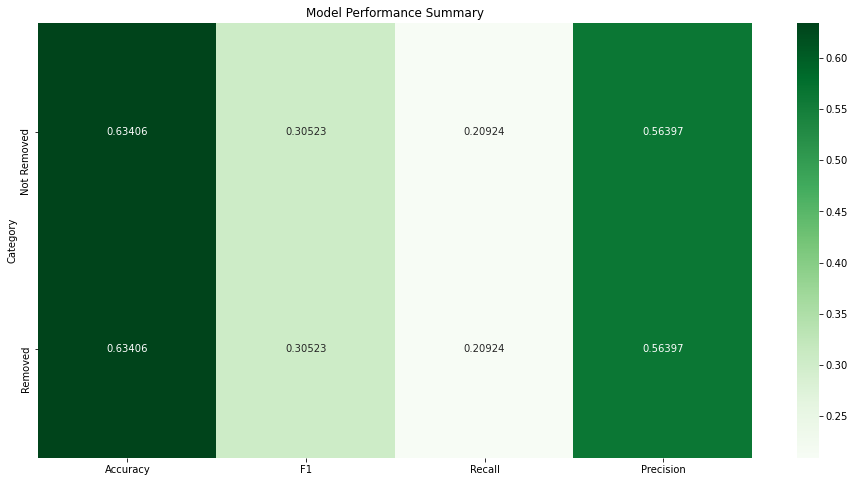

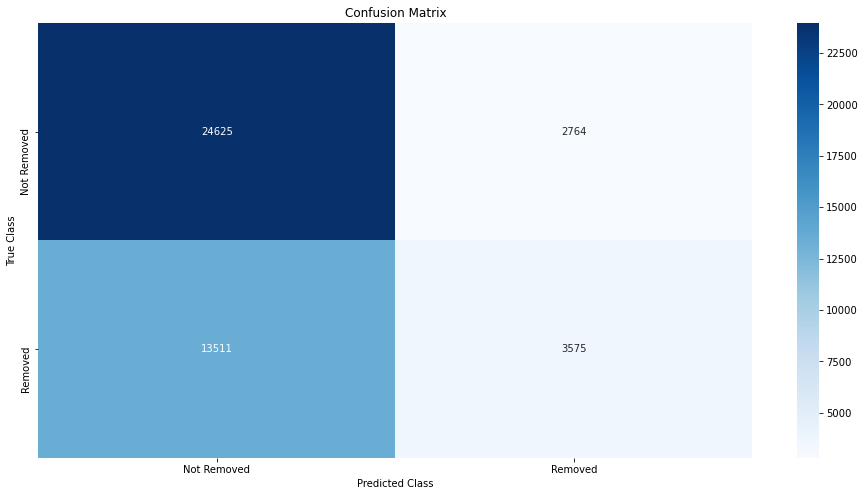

In [12]:
#NB with stopwords removed and lemmatizing (also higher max features)
X = data_cleaned['clean_string']
y = data_cleaned['REMOVED']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=8492)

tfidf = TfidfVectorizer(max_features=300)

X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

NB_stop_lemma = MultinomialNB()
NB_stop_lemma.fit(X_train_vectorized, y_train)

test_NB_stop_lemma = getScore(NB_stop_lemma, X_test_vectorized, y_test, labels)
conf_NB_stop_lemma = getConfusionMatrix(NB_stop_lemma, X_test_vectorized, y_test, labels)

In [13]:
#very slightly better than baseline, still barely better than always picking majority

In [14]:
#insert autoembedding lstm here

In [15]:
#use this same split for w2v lstm
X = data_cleaned['clean_string']
y = data_cleaned['REMOVED']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=8492)

if exists('models/w2v_1'):
    w2v = gensim.models.word2vec.Word2Vec.load('models/w2v_1')
    
else:


    w2v_train = X_train.copy()

    #turn into list of lists for gensim
    w2v_train_list = []
    for text in w2v_train:
        list_words = text.split() #is this right?
        w2v_train_list.append(list_words)

    #train w2v
    w2v = gensim.models.word2vec.Word2Vec(w2v_train_list, size=300,   
                window=8, min_count=1, sg=1, iter=30)

    w2v.save('models/w2v_1')

In [16]:
#get y vals
y_train_final = y_train.astype(int).to_numpy()
y_test_final = y_test.astype(int).to_numpy()


train_list = X_train.to_list()
train_list_tokenized = []
for string in train_list:
    train_list_tokenized.append(string.split(' '))
    
print(train_list_tokenized[0:10])

test_list = X_test.to_list()
test_list_tokenized = []
for string in test_list:
    test_list_tokenized.append(string.split(' '))
    

#fit tokenizer, get vocab

tokenizer = tensorflow.keras.preprocessing.text.Tokenizer(lower=False, #already lowered
                                                          split=' ', 
                                                          oov_token="NaN", 
                                                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(train_list_tokenized)
vocabulary = tokenizer.word_index
#print(vocabulary)

#get sequence

train_sequence = tokenizer.texts_to_sequences(train_list_tokenized)

test_sequence = tokenizer.texts_to_sequences(test_list_tokenized)

#apply padding

train_seq_padded = tensorflow.keras.preprocessing.sequence.pad_sequences(train_sequence, 
                                                                         maxlen=15, 
                                                                         padding="post", 
                                                                         truncating="post")

test_seq_padded = tensorflow.keras.preprocessing.sequence.pad_sequences(test_sequence,
                                                                        maxlen=15, 
                                                                        padding='post', 
                                                                        truncating='post')

[['lot', 'people', 'read', 'headline', 'conclude', 'acupuncture', 'effective', 'much', 'likely', 'study', 'show', 'painkiller'], ['confirm', 'never', 'anything', 'worse', 'flu', 'flu', 'two', 'year', 'despite', 'fact', 'immunized'], ['pirate', 'pancreas'], ['oh', 'man', 'big', 'pharma', 'got', 'pissed'], ['understand', 'california', 'may', 'soon', 'require', 'labelling', 'coffee', 'carcinogen'], ['easier', 'fool', 'someone', 'convince', 'someone', 'fooled'], ['cannot', 'read', 'title'], ['want', 'watch', 'child', 'fighting', 'happened', 'tribal', 'warfare', 'today', 'like', 'congo', 'warlord'], ['assume', 'lack', 'paid', 'holiday', 'maternity', 'leave', 'much', 'effect', 'work', 'civilised', 'world'], ['keep', 'getting', 'posted', 'correlation', 'equal', 'causation', 'many', 'factor', 'declining', 'teen', 'pregnancy', 'rate']]


In [17]:
#get embeddings

#create blank matrix
embed_matrix = np.zeros((len(vocabulary)+1, 300))

for word, index in vocabulary.items():
    try:
        embed_matrix[index] =  w2v[word]
        
    #skip word if not in w2v model
    except:
        pass

<ipython-input-17-09ef6e586e97>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embed_matrix[index] =  w2v[word]


In [18]:
#check embed matrix
word = "movie"
print("word index in vocab:", vocabulary[word])
print("embed matrix at index:\n", embed_matrix[vocabulary[word]])

word index in vocab: 1107
embed matrix at index:
 [ 3.04814667e-01 -3.30893874e-01  6.20078921e-01 -2.70033479e-01
 -3.04309189e-01 -9.68737304e-01 -5.18821239e-01  2.31849119e-01
 -3.59101832e-01  2.71909326e-01 -1.10163771e-01 -1.57429073e-02
 -6.29382670e-01 -1.09602265e-01 -1.07467659e-01 -2.54057497e-01
  3.54045808e-01 -8.42597112e-02 -1.69767722e-01 -1.25486255e-01
 -8.30214545e-02  1.00790888e-01  3.19447219e-01 -3.47862951e-02
  3.34237009e-01  4.56495970e-01 -6.30232468e-02 -2.00908512e-01
 -4.70518470e-02 -6.58595338e-02  5.04337311e-01  3.93077850e-01
 -3.04118335e-01 -2.00868517e-01  3.89979869e-01  5.15015483e-01
  1.97262630e-01  3.95818613e-02 -2.77788818e-01 -5.93370497e-01
 -1.50361314e-01 -3.04918319e-01  3.47348750e-01 -2.90700555e-01
  1.58025414e-01 -2.02244908e-01  3.24453294e-01  4.26011741e-01
  3.28097455e-02  2.17290834e-01  1.33585602e-01  4.61078614e-01
 -2.01409280e-01 -2.35717192e-01  3.13056618e-01 -6.43161535e-02
 -1.58439323e-01  1.60315111e-01  1.0289

In [19]:
#w2v lstm

if exists('models/lstm_w2v'):
    lstm_w2v = models.load_model('models/lstm_w2v')

else:
    lstm_w2v = models.Sequential()
    lstm_w2v.add(layers.Input(shape=(15,)))
    lstm_w2v.add(layers.Embedding(input_dim=embed_matrix.shape[0],
                                    output_dim=embed_matrix.shape[1],
                                    weights=[embed_matrix],
                                    input_length=15,
                                    trainable=False))
    
    lstm_w2v.add(layers.Bidirectional(layers.LSTM(units=15,
                                                    dropout=0.2,
                                                    return_sequences=True)))
    
    lstm_w2v.add(layers.Bidirectional(layers.LSTM(units=15,
                                                    dropout=0.2)))
    
    lstm_w2v.add(layers.Dense(64, activation='relu'))
    lstm_w2v.add(layers.Dense(32, activation='relu'))
    
    lstm_w2v.add(layers.Dense(2, activation='softmax'))
    
    lstm_w2v.compile(loss='sparse_categorical_crossentropy',
                       optimizer='sgd',
                       metrics=['accuracy'])
    
    lstm_w2v.summary()
    
    results_lstm_w2v = lstm_w2v.fit(train_seq_padded, y_train_final,
                                        epochs=16,
                                        batch_size=128,
                                        validation_split=0.3,
                                        verbose=1)
    
    #need to implement result saving methods from p4
    
    lstm_w2v.save('models/lstm_w2v')

In [20]:
#test model performance
lstm_w2v.evaluate(test_seq_padded, y_test_final)

#69% accuracy, nice improvement over NB models

1390/1390 [==============================] - 12s 6ms/step - loss: 0.5614 - accuracy: 0.6912


[0.561391294002533, 0.6912422776222229]

In [21]:
#try and setup standalone lstm
lstm_base = models.Sequential()
lstm_base.add(layers.Input(shape=(15,)))
lstm_base.add(layers.Embedding(input_dim=embed_matrix.shape[0],
                                output_dim=embed_matrix.shape[1],
                                #weights=[embed_matrix],
                                input_length=15,
                                trainable=True))
    
lstm_base.add(layers.Bidirectional(layers.LSTM(units=15,
                                                dropout=0.2,
                                                return_sequences=True)))
    
lstm_base.add(layers.Bidirectional(layers.LSTM(units=15,
                                                dropout=0.2)))
    
lstm_base.add(layers.Dense(64, activation='relu'))
lstm_base.add(layers.Dense(32, activation='relu'))
    
lstm_base.add(layers.Dense(2, activation='softmax'))
    
lstm_base.compile(loss='sparse_categorical_crossentropy',
                    optimizer='sgd',
                     metrics=['accuracy'])
    
lstm_base.summary()
    
results_lstm_base = lstm_base.fit(train_seq_padded, y_train_final,
                                    epochs=16,
                                    batch_size=128,
                                    validation_split=0.3,
                                    verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 300)           32178000  
                                                                 
 bidirectional (Bidirectiona  (None, 15, 30)           37920     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 30)               5520      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                1984      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 6

In [22]:
#so it *is* that simple
lstm_base.evaluate(test_seq_padded, y_test_final)
#66% accuracy. not bad for learning on its own.

1390/1390 [==============================] - 8s 5ms/step - loss: 0.5890 - accuracy: 0.6674


[0.5890087485313416, 0.6674086451530457]

In [22]:
#prediction function for lime
#will probably need to move this up to work with eventual basic embedding lstm
def lime_predict_lstm(text, predict_func):

    final_output = []
    predict_input = []
    for text_variant in text:

        #tokenize
        input_list_tokenized = [text_variant.split(' ')]
        print(input_list_tokenized)

        #sequence
        input_sequence = tokenizer.texts_to_sequences(input_list_tokenized)

        #padding
        input_seq_padded = tensorflow.keras.preprocessing.sequence.pad_sequences(input_sequence,
                                                                                 maxlen=15, 
                                                                                 padding='post', 
                                                                                 truncating='post')

        predict_input.append(input_seq_padded[0].tolist())
    
    
    predict_output = predict_func(predict_input)
    #print(predict_output)
    
    return predict_output

In [23]:
#get glove embeddings
glove = dict()

#file not present currently
#glove file is aroung 1gb, need to find a way to download via notebook
#also please remember to add to gitignore
with open('data/glove/glove.6B.300d.txt', 'r', encoding='utf8') as f:
    w = 0
    for line in f.readlines():
        line = line.split(' ')
        
        try:
            glove[line[0]] = np.array(line[1:], dtype=float)
            
        except:
            print('failed on line', w)
            continue
            
embed_matrix_glove = np.zeros((len(vocabulary)+1, 300))

for word, index in vocabulary.items():
    try:
        embed_matrix_glove[index] =  glove[word]
    #skip word if not in glove model
    except:
        pass

In [24]:
#glove embedding lstm

if exists('models/lstm_glove'):
    lstm_glove = models.load_model('models/lstm_glove')

else:
    lstm_glove = models.Sequential()
    lstm_glove.add(layers.Input(shape=(15,)))
    lstm_glove.add(layers.Embedding(input_dim=embed_matrix_glove.shape[0],
                                    output_dim=embed_matrix_glove.shape[1],
                                    weights=[embed_matrix_glove],
                                    input_length=15,
                                    trainable=False))
    
    lstm_glove.add(layers.Bidirectional(layers.LSTM(units=15,
                                                    dropout=0.2,
                                                    return_sequences=True)))
    
    lstm_glove.add(layers.Bidirectional(layers.LSTM(units=15,
                                                    dropout=0.2)))
    
    lstm_glove.add(layers.Dense(64, activation='relu'))
    lstm_glove.add(layers.Dense(32, activation='relu'))
    
    lstm_glove.add(layers.Dense(2, activation='softmax'))
    
    lstm_glove.compile(loss='sparse_categorical_crossentropy',
                       optimizer='sgd',
                       metrics=['accuracy'])
    
    lstm_glove.summary()
    
    results_lstm_glove = lstm_glove.fit(train_seq_padded, y_train_final,
                                        epochs=16,
                                        batch_size=128,
                                        validation_split=0.15,
                                        verbose=1)
    lstm_glove.save('models/lstm_glove')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 15, 300)           32178000  
                                                                 
 bidirectional_2 (Bidirectio  (None, 15, 30)           37920     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 30)               5520      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                1984      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 2)                

INFO:tensorflow:Assets written to: models/lstm_glove\assets


INFO:tensorflow:Assets written to: models/lstm_glove\assets


In [26]:
#test model
lstm_glove.evaluate(test_seq_padded, y_test_final)

1390/1390 [==============================] - 10s 7ms/step - loss: 0.5805 - accuracy: 0.6759


[0.5804761648178101, 0.6758853197097778]

In [27]:
#get dataset for transformer model
data_tf_all = data_cleaned.copy()
data_tf_all['label'] = data_tf_all['REMOVED'].astype(int)
data_tf_all.drop(['body', 'REMOVED', 'tokenized', 'no_stop', 'lemma'], axis=1, inplace=True)
ds_all = Dataset.from_pandas(data_tf_all)



In [28]:
#preprocess transformer dataset
tf_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
collator = DataCollatorWithPadding(tokenizer=tf_tokenizer, return_tensors='tf')

def tf_tokenize_func(input_dataset):
    return tf_tokenizer(input_dataset['clean_string'], truncation=True)

ds_tokenized = ds_all.map(tf_tokenize_func, batched = True)

  0%|          | 0/223 [00:00<?, ?ba/s]

In [29]:
#split transformer data
ds_final = ds_tokenized.train_test_split(test_size=0.1, shuffle=True)

select_batch_size = 32

tf_train_set = ds_final["train"].to_tf_dataset(

    columns=["attention_mask", "input_ids", "label"],

    shuffle=True,

    batch_size=select_batch_size,

    collate_fn=collator,

)

tf_validation_set = ds_final["test"].to_tf_dataset(

    columns=["attention_mask", "input_ids", "label"],

    shuffle=False,

    batch_size=select_batch_size,

    collate_fn=collator,

)

In [32]:
#setup transformer model
num_epochs = 5

batches_per_epoch = len(ds_final["train"]) // select_batch_size

total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

distilbert = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

distilbert.compile(optimizer=optimizer)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [33]:
#fit transformer model
distilbert.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=num_epochs)

Epoch 1/5
   2/6255 [..............................] - ETA: 23:40:22 - loss: 0.6793

KeyboardInterrupt: 